In [1]:
import pandas as pd
import numpy as np
from openpyxl import Workbook
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Download the VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\UNOCC-
[nltk_data]     data\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Read a sample of 50 sentence extractions from Diplomatic Pulse Data
ds_data = pd.read_excel('50sample_extractions_moreRestrictive.xlsx')
columns_to_check = ['positive_israel', 'negative_israel', 'positive_opt', 'negative_opt','positive_hamas','negative_hamas']

# Drop rows where all specified columns contain empty strings
ds_data = pd.read_excel('50sample_extractions_moreRestrictive.xlsx')
#ds_data = data1[~data1[columns_to_check].eq('[]').all(axis=1)]
ds_data = ds_data.rename(columns={'Unnamed: 0': 'SId'})
# Store the original data in a new DataFrame
#data = ds_data
data = ds_data.copy()

In [3]:
idx_extraction = ds_data.columns.get_loc('positive_israel')
def clean_extractions(df):
    """
    Function that cleans extractions in the input DataFrame by converting them to strings & removing brackets
    """
    for column in df.columns[idx_extraction:(idx_extraction+6)]:
        df[column] = df[column].astype(str)
        df[column] = df[column].str.replace("[", "",regex=False)
        df[column] = df[column].str.replace("]", "",regex=False)
        df[column] = df[column].str.replace('[]', "",regex=False)
    return df

ds_data= clean_extractions(ds_data)

In [4]:
score_pos_israel = "Vader_positive_israel"
score_neg_israel = "Vader_negative_israel"
score_pos_opt = "Vader_positive_opt"
score_neg_opt = "Vader_negative_opt"
score_pos_hamas = "Vader_positive_hamas"
score_neg_hamas = "Vader_negative_hamas"

fields_list = [score_pos_israel, score_neg_israel, score_pos_opt, score_neg_opt, score_pos_hamas, score_neg_hamas]

In [5]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def sentiment_Vader(text,desired_type:str='pos'):
    all_polarity = analyzer.polarity_scores(text)
    return all_polarity[desired_type]

def get_sentiment_scores(ds_data=ds_data, df=data):
    """
    Function that takes a cleaned dataframe and original dataframe. Returns original dataframe plus sentiment scores calculated using the cleaned dataframe.
    Keeps the absolute values of scores for positive sentences, and -1 * absolute value of scores for the negative sentences
    """
    for i in range(0, len(fields_list)):
        score = []
        column_index = idx_extraction + i
        score = ds_data.iloc[:,column_index].astype(str).apply(lambda x: sentiment_Vader(x,'compound'))
        df.loc[:,fields_list[i]] = score
    
    #Get index of the first score column, i.e. for positive_israel
    col_idx_score = df.columns.get_loc(fields_list[0])
    # Keep the absolute values for positive sentences, and -1 * absolute value for the negative sentences
    positive_extractions = [col_idx_score, (col_idx_score+2), (col_idx_score+4)]
    negative_extractions = [(col_idx_score+1), (col_idx_score+3), (col_idx_score+5)]
    df.iloc[:, positive_extractions] = df.iloc[:, positive_extractions].abs()
    df.iloc[:, negative_extractions] = -df.iloc[:, negative_extractions].abs()

    # Write the DataFrame to an Excel file
    df.to_excel('vader-SentimentScores-DiplomaticPulseIsraelPalestine-SampleData.xlsx', index=False)
    return df



In [6]:
scores = get_sentiment_scores(ds_data=ds_data, df=data)

In [7]:
# Get consolidated scores for each entity-Israel, oPt, Hamas by differencing the positive and negative scores. Store these scores in the original DataFrame
col_idx_score = data.columns.get_loc(fields_list[0])
data['Vader-Israel'] = data.iloc[:,col_idx_score] + data.iloc[:,(col_idx_score+1)]
data['Vader-Palestine'] = data.iloc[:,(col_idx_score+2)] + data.iloc[:,(col_idx_score+3)]
data['Vader-Hamas'] = data.iloc[:,(col_idx_score+4)] + data.iloc[:,(col_idx_score+5)]
data = data.drop(columns=fields_list)
data.head()

,SId,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,Vader-Israel,Vader-Palestine,Vader-Hamas
0,1,"['During her trip, the Minister will reaffirm ...",[],[],[],[],['discuss the impacts of Hamas’ terrorist atta...,0.4019,0.0000,-0.8316
1,2,"['As a friend to both Israel and Palestine, wh...",[],"['As a friend to both Israel and Palestine, wh...",[],[],['We oppose and condemn acts harming civilians.'],0.9517,0.9477,-0.7351
2,3,['the Foreign Minister expressed solidarity wi...,[],[],['Krišjānis Kariņš underlined the need for...,[],['following the violent attack by the Hamas te...,0.2960,-0.6486,-0.9136
3,4,"['Yesterday, I wrote to Israeli Foreign Minist...",[],[],[],[],['I again unreservedly condemn the attack by H...,0.0000,0.0000,-0.6908
4,5,['your visit is another tangible example of Am...,[],['We know Hamas doesn’t represent the Palestin...,[],[],['Hamas has shown itself to be an enemy of civ...,0.9937,0.9201,-0.8957


In [8]:
# Save consolidated scores in a dataframe
pred_scores = data.loc[:,['Vader-Israel','Vader-Palestine','Vader-Hamas']]

# Read file with ground-truth scores and get the average scores for each entity                 
gtdata= pd.read_excel('AverageSentiment Scoring-RLU-DiplomaticPulse-Israel-oPt_issuingCountry.xlsx')
actual_avgscores = gtdata.iloc[:,12:15]

# Match index of ground truth scores with predicted scores because empty extractions were filtered out
acs = actual_avgscores.loc[data.index]
#acs.head()

In [9]:
mae_results = pd.DataFrame()

individual_maes = []
for i in range(3):
    abs_diff = abs(pred_scores.iloc[:, i] - acs.iloc[:, i])
    mae = np.mean(abs_diff)
    mae_results[i] = [mae]
    individual_maes.append(mae)

# Calculate overall MSE
overall_mae = np.mean(individual_maes)
mae_results['Overall'] = [overall_mae]

mae_results.index = ['MAE']
print(mae_results)

            0         1         2  Overall
MAE  0.298581  0.170894  0.191214  0.22023


In [10]:
mse_results = pd.DataFrame()

individual_mses = []
for i in range(3):
    squared_diff = (pred_scores.iloc[:, i] - acs.iloc[:, i]) ** 2
    mse = np.mean(squared_diff)
    mse_results[i] = [mse]
    individual_mses.append(mse)

# Calculate overall MSE
overall_mse = np.mean(individual_mses)
mse_results['Overall'] = [overall_mse]

mse_results.index = ['MSE']
print(mse_results)

            0         1         2   Overall
MSE  0.171256  0.083297  0.081678  0.112077


In [11]:
summary=pd.concat([mae_results,mse_results])
summary.columns = ['Israel', 'oPt','Hamas','Overall']
summary

,Israel,oPt,Hamas,Overall
MAE,0.298581,0.170894,0.191214,0.220230
MSE,0.171256,0.083297,0.081678,0.112077


In [12]:
# Get average ground truth scores in data
data['gt-score_israel'] = acs['Israel.3']
data['gt-score_opt'] = acs['Occupied Palestine Territory.3']
data['gt-score_hamas'] = acs['Hamas.3']
data.head()

,SId,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,Vader-Israel,Vader-Palestine,Vader-Hamas,gt-score_israel,gt-score_opt,gt-score_hamas
0,1,"['During her trip, the Minister will reaffirm ...",[],[],[],[],['discuss the impacts of Hamas’ terrorist atta...,0.4019,0.0000,-0.8316,0.666667,0.250000,-0.750000
1,2,"['As a friend to both Israel and Palestine, wh...",[],"['As a friend to both Israel and Palestine, wh...",[],[],['We oppose and condemn acts harming civilians.'],0.9517,0.9477,-0.7351,0.000000,0.250000,-0.083333
2,3,['the Foreign Minister expressed solidarity wi...,[],[],['Krišjānis Kariņš underlined the need for...,[],['following the violent attack by the Hamas te...,0.2960,-0.6486,-0.9136,0.583333,-0.250000,-0.750000
3,4,"['Yesterday, I wrote to Israeli Foreign Minist...",[],[],[],[],['I again unreservedly condemn the attack by H...,0.0000,0.0000,-0.6908,0.416667,0.250000,-0.833333
4,5,['your visit is another tangible example of Am...,[],['We know Hamas doesn’t represent the Palestin...,[],[],['Hamas has shown itself to be an enemy of civ...,0.9937,0.9201,-0.8957,1.000000,0.083333,-0.916667


In [13]:
# Create 5 equal sized classes in the range -1 to 1 and classify both predicted and average ground truth scores
def to_sentiment(score):
  score = score
  if score <= -0.6:
    return "strong negative"
  elif score > -0.6 and score <= -0.2:
    return "weak negative"
  elif score > -0.2 and score < 0.2:
    return "neutral"
  elif score >=0.2 and score < 0.6:
    return "weak positive"
  elif score >= 0.6:
    return "strong positive"

data['sentiment_israel'] = data['Vader-Israel'].apply(lambda x: to_sentiment(x))
data['sentiment_opt'] = data['Vader-Palestine'].apply(lambda x: to_sentiment(x))
data['sentiment_hamas'] = data['Vader-Hamas'].apply(lambda x: to_sentiment(x))
data[['gt_israel', 'gt_opt', 'gt_hamas']] = acs[['Israel.3','Occupied Palestine Territory.3','Hamas.3']].applymap(to_sentiment)
data.head()

,SId,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,Vader-Israel,Vader-Palestine,Vader-Hamas,gt-score_israel,gt-score_opt,gt-score_hamas,sentiment_israel,sentiment_opt,sentiment_hamas,gt_israel,gt_opt,gt_hamas
0,1,"['During her trip, the Minister will reaffirm ...",[],[],[],[],['discuss the impacts of Hamas’ terrorist atta...,0.4019,0.0000,-0.8316,0.666667,0.250000,-0.750000,weak positive,neutral,strong negative,strong positive,weak positive,strong negative
1,2,"['As a friend to both Israel and Palestine, wh...",[],"['As a friend to both Israel and Palestine, wh...",[],[],['We oppose and condemn acts harming civilians.'],0.9517,0.9477,-0.7351,0.000000,0.250000,-0.083333,strong positive,strong positive,strong negative,neutral,weak positive,neutral
2,3,['the Foreign Minister expressed solidarity wi...,[],[],['Krišjānis Kariņš underlined the need for...,[],['following the violent attack by the Hamas te...,0.2960,-0.6486,-0.9136,0.583333,-0.250000,-0.750000,weak positive,strong negative,strong negative,weak positive,weak negative,strong negative
3,4,"['Yesterday, I wrote to Israeli Foreign Minist...",[],[],[],[],['I again unreservedly condemn the attack by H...,0.0000,0.0000,-0.6908,0.416667,0.250000,-0.833333,neutral,neutral,strong negative,weak positive,weak positive,strong negative
4,5,['your visit is another tangible example of Am...,[],['We know Hamas doesn’t represent the Palestin...,[],[],['Hamas has shown itself to be an enemy of civ...,0.9937,0.9201,-0.8957,1.000000,0.083333,-0.916667,strong positive,strong positive,strong negative,strong positive,neutral,strong negative


In [14]:
class_names=['strong negative', 'weak negative', 'neutral','weak positive','strong positive']
titles = ['Israel', 'oPt', 'Hamas']
#Israel
x1=data.iloc[:,16] #ground-truth
y1=data.iloc[:,13] #predicted
cm1 = confusion_matrix(x1, y1, labels=class_names)
#oPt
x2=data.iloc[:,17]
y2=data.iloc[:,14]
cm2 = confusion_matrix(x2, y2, labels=class_names)
#Hamas
x3=data.iloc[:,18]
y3=data.iloc[:,15]
cm3 = confusion_matrix(x3, y3, labels=class_names)

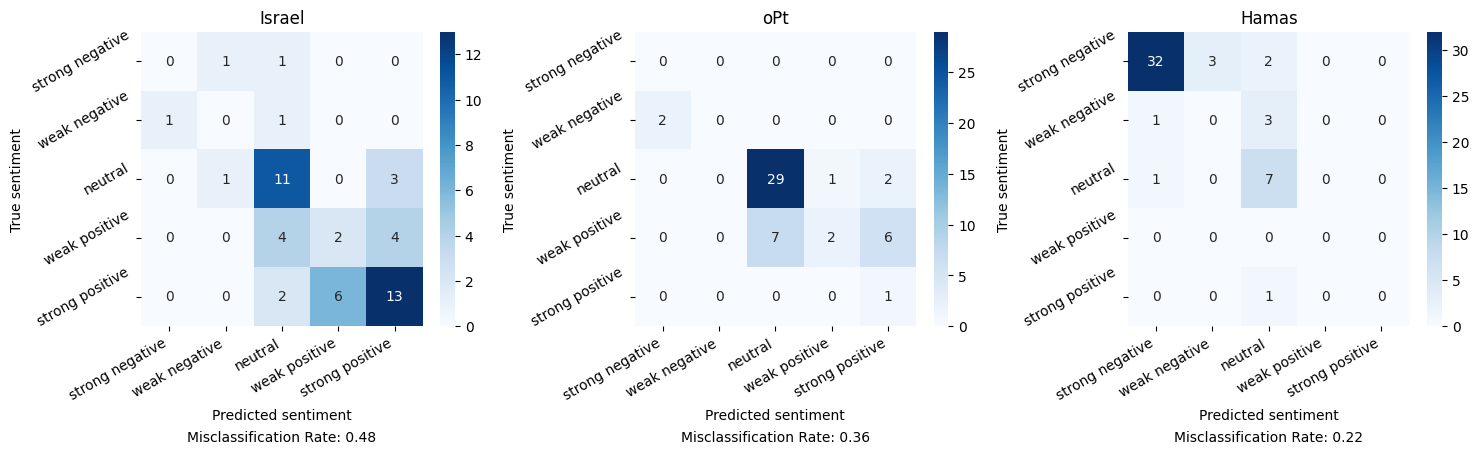

In [15]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    # Set the title for the subplot
    ax.set_title(titles[i])
    # Create a heatmap for each confusion matrix
    if i == 0:
        confusion_matrix = cm1
    elif i == 1:
        confusion_matrix = cm2
    else:
        confusion_matrix = cm3
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=class_names, yticklabels=class_names)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=30, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    
    # Set axis labels
    ax.set_xlabel('Predicted sentiment')
    ax.set_ylabel('True sentiment')
    
    # Calculate and display misclassification rate
    total = np.sum(confusion_matrix)
    misclassified = total - np.trace(confusion_matrix)
    misclassification_rate = misclassified / total
    ax.text(0.5, -0.39, f'Misclassification Rate: {misclassification_rate:.2f}', ha='center', transform=ax.transAxes)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
fig = plt.figure()

#plt.savefig('gpt35-equalboundary.png', transparent=False)
plt.close()

In [16]:
writer = pd.ExcelWriter('Vader-equalBC-DiplomaticPulseData.xlsx', engine='openpyxl')
data.to_excel(writer, sheet_name='Main', index=False)
ds_data.to_excel(writer, sheet_name='All_scores', index=False)
summary.to_excel(writer, sheet_name='Summary', index=True)
writer.book.save('Vader-equalBC-DiplomaticPulseData.xlsx')

Confidence Intervals for Israel, oPt, and Hamas scores

In [17]:
np.random.seed(101)
entity=['Israel', 'oPt','Hamas']
for j in range(0,3):
    # Sample predicted and ground truth sentiment scores
    predicted_scores = pred_scores.iloc[:,j]
    ground_truth_scores = acs.iloc[:,j]

    # Number of bootstrap resamples
    num_resamples = 1000
    confidence_level = 0.95  

    # Calculate the differences between predicted and ground truth scores
    difference_scores = np.array(predicted_scores) - np.array(ground_truth_scores)
    bootstrap_means = np.empty(num_resamples)
    # Bootstrap resampling and mean calculation
    for i in range(num_resamples):
        #Resample with replacement
        resample_indices = np.random.choice(len(difference_scores), size=len(difference_scores), replace=True)
    
        # Calculate the mean difference for the resampled dataset
        bootstrap_means[i] = np.mean(difference_scores[resample_indices])

    # Calculate the confidence interval
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (confidence_level + (1 - confidence_level) / 2) * 100
    confidence_interval = np.percentile(bootstrap_means, [lower_percentile, upper_percentile])

    print(f"For {entity[j]}, {int(confidence_level * 100)}% Confidence Interval for Difference:", confidence_interval)
    print(f"Width of Confidence Interval : {confidence_interval[1]-confidence_interval[0]}")

For Israel, 95% Confidence Interval for Difference: [-0.11646113  0.11363912]
Width of Confidence Interval : 0.23010024999999998
For oPt, 95% Confidence Interval for Difference: [-0.05552023  0.10231197]
Width of Confidence Interval : 0.15783219999999998
For Hamas, 95% Confidence Interval for Difference: [-0.05506538  0.10446755]
Width of Confidence Interval : 0.15953293333333332
